<a href="https://colab.research.google.com/github/crisalex25/TFM_HydroMLGenerationOptimization/blob/main/TFM_Optimizaci%C3%B3n_de_la_generaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo de Fin de Master**
## **Máster Universitario en Inteligencia Artificial para el Sector de la Energía y las Infraestructuras**
Optimización de generación en centrales hidroeléctricas mediante técnicas de aprendizaje automático

##Optimización

Librerías

In [105]:
!pip install deap

In [106]:
'''
    LIBRERIAS
    ---------------------------------------------------------
'''
# Librerías de Algoritmos genéticos
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# Librerías auxiliares
import matplotlib.pyplot as plt

# Librerías auxiliares
from operator import truediv
import numpy as np
import random
import time

In [107]:
#Registro el tiempo de inicio del programa
t0 = time.time()

Variables y parámetros

In [108]:
numeroGenesTotal= 72
numeroCromosomas=3
numeroGenesPorCromosoma= int(numeroGenesTotal/numeroCromosomas)
probCruce=0.7            #Probabilidad de cruce
probMutacion=0.3         #Probabilidad de mutación
num_generaciones= 300    #Numero de generaciones
tamaño_poblacion = 300   #Tamaño de la población
penaliza=9999999.9

P_min_G1=400.0    #Potencia mínima que puede producir el generador 1 Papallacta
P_max_G1=1800.0   #Potencia máxima que puede producir el generador 1 Papallacta
P_max_G2=4200.0   #Potencia máxima que puede producir el generador 2 Papallacta
P_min_G2=1700.0   #Potencia mínima que puede producir el generador 2 Papallacta
P_max_G3=2100.0   #Potencia máxima que puede producir el generador 3 Loreto
P_min_G3=500.0   #Potencia mínima que puede producir el generador 3 Loreto

#Demanda de potencia energética que se debe satisfacer
demandaConsumoPorHoras_GC = [1200, 1333, 1444, 1884, 1884, 1884, 1884, 1884, 1884, 1484, 1584, 1284,
                             1684, 1784, 1684, 1114, 1284, 1384, 1884, 1884, 1884, 1884, 1884, 1700]
demandaConsumoPorHoras_AC = [4811, 4787, 4778, 4780, 4856, 4878, 4853, 4901, 5082, 5250, 5292, 5305,
                             5103, 5219, 5266, 5258, 5311, 5138, 4989, 4876, 4745, 4876, 4833, 4845]
precio_energia = [6.19, 8.39, 6.19, 6.19, 5.35, 6.48, 5.35, 5.35, 6.19, 6.19, 6.19, 6.48,
                  6.19, 6.48, 6.19, 6.48, 6.19, 6.19, 9.46, 9.46, 8.96, 6.19, 6.19, 6.19]
horas = [0,1,2,3,4, 5, 6, 7, 8, 9, 10,11,12,13,14,15, 16,17,18,19,20,21,22,23]

Funciones Auxiliares

In [109]:
#Sección que contiene funciones auxiliares propias del dominio del problema a resolver

#Función que obtiene el coste en € que correspondiente al generador diesel de producir una potencia determinada
def getCosteDiesel(potencia):
    return float((potencia) * 0.008)

#Función que obtiene el coste en € que correspondiente al generador de gas de producir una potencia determinada
def getCosteGas(potencia):
    return float(potencia * 0.0025)

#Función que obtiene el coste en € que correspondiente al generador de gas de producir una potencia determinada
def getCosteG3(potencia):
    return float(potencia * 0.0019)

#Función que muestra un gráfico con los datos de las potencias contenidas en un individuo.
def dibujarGrafico(individuo, demandaConsumoPorHoras, horas,tituloGrafico):
        individuo1 = np.zeros(numeroGenesPorCromosoma)
        for i in range(0,numeroGenesPorCromosoma):
            individuo1[i]=individuo[i] #Generador G1 Papallacta

        individuo2 = np.zeros(numeroGenesPorCromosoma)
        for i in range(0,numeroGenesPorCromosoma):
            individuo2[i]=individuo[i+numeroGenesPorCromosoma] #Generador G2 Papallacta

        individuo3 = np.zeros(numeroGenesPorCromosoma)
        for i in range(0,numeroGenesPorCromosoma):
            individuo3[i]=individuo[i+numeroGenesPorCromosoma*2] #Generador G3 Loreto

        plt.bar(horas, individuo1 + individuo2 , label='G2',color='green')
        plt.bar(horas, individuo1 , label='G1',color='blue')
        plt.plot(horas,demandaConsumoPorHoras_AC,'*--', label='Demanda AutoConsumo' )
        plt.ylabel('Potencia (Kw)')
        plt.xlabel('Horas (0 - 24)')
        plt.title(tituloGrafico)
        #agregar segundo grafico

        plt.legend(loc='best')
        plt.show()

#La función realiza varias comprobaciones para saber si un individuo es válido.
def individuoIsValid(x):

    #Elimino valores negativos
    for i in range(0,numeroGenesPorCromosoma*3):
        if (x[i] < float(0.0)):
            return False

    #El generador G1 debe generar más potencia de 400 kw para que funcione
    for i in range(0,numeroGenesPorCromosoma):
        if (x[i]>0.0 and x[i]< P_min_G1):
            return False

    #El generador G2 debe generar más potencia de 1700 kw para que funcione
    for i in range(numeroGenesPorCromosoma,numeroGenesPorCromosoma*2):
        if (x[i]>0.0 and x[i]< P_min_G2):
            return False

    #El generador G3 debe generar más potencia de 2100 kw para que funcione
    for i in range(numeroGenesPorCromosoma*2,numeroGenesPorCromosoma*3):
        if (x[i]>0.0 and x[i]< P_min_G3):
            return False

    #Compruebo que el generador 1 solo puede tener asignada como máxima su maximo permitido
    for i in range(0,numeroGenesPorCromosoma):
        if (x[i] > P_max_G1):
            return False

    #Compruebo que el generador 2 solo puede tener asignada como máxima su maximo permitido
    for i in range(numeroGenesPorCromosoma,numeroGenesPorCromosoma*2):
       if (x[i] > P_max_G2):
            return False

    #Compruebo que el generador 3  solo puede tener asignada como máxima su maximo permitido
    for i in range(numeroGenesPorCromosoma*2,numeroGenesPorCromosoma*3):
       if (x[i] > P_max_G3):
            return False

    #Compruebo si el individuo satisface la demanda energética AC
    for i in range(len(demandaConsumoPorHoras_AC)):
        demandaAsatistacer_AC = float(demandaConsumoPorHoras_AC[i])
        diferencia= demandaAsatistacer_AC - float(x[i]) - float(x[i+numeroGenesPorCromosoma])
        if (diferencia > 0.0):
            return False
    return True

    #Compruebo si el individuo satisface la demanda energética GC
    for i in range(len(demandaConsumoPorHoras_GC)):
        demandaAsatistacer_GC = float(demandaConsumoPorHoras_GC[i])
        diferencia= demandaAsatistacer_GC - float(x[i+numeroGenesPorCromosoma*2])
        if (diferencia > 0.0):
            return False
    return True


FUnciones Auxiliares

In [110]:
'''
    FUNCIONES AUXILIARES DEL AG
    ---------------------------------------------------------
'''
# Función para la creación de individuos iniciales
def crea_individuo():   # Creación de individuos iniciales
    cromosoma = np.zeros(numeroGenesTotal)

    # Asigno potencias aleatoriamente para el generador diesel
    for i in range(0,numeroGenesPorCromosoma):
        cromosoma[i] =float(np.random.uniform(P_min_G1, P_max_G1) )

    # Asigno potencias aleatoriamente para el generador de gas
    for i in range(numeroGenesPorCromosoma, numeroGenesPorCromosoma*2):
        cromosoma[i] =float(np.random.uniform(P_min_G2, P_max_G2) )

    # Asigno potencias aleatoriamente para el generador de gas
    for i in range(numeroGenesPorCromosoma*2, numeroGenesPorCromosoma*3):
        cromosoma[i] =float(np.random.uniform(P_min_G2, P_max_G2) )

    #Formateo los valores del cromosoma a decimal con 2 decimales
    for i in range(0, numeroGenesPorCromosoma*3):
        cromosoma[i] = float("{:.2f}".format(cromosoma[i]))  #Doy formato al valor

    return cromosoma


#Función que aplica el operador de mutación para un indivudo dado
def mutacion(individuo):
    #Compruebo que al hacer los operadores de cruce no hay numeros negativos
    if (individuoIsValid(individuo) == False):
        return individuo,  #Individuo no válido así que no aplico mutacion

    #Decido el gen que se va modificar
    random_gen_a_modificar = random.randint(0, numeroGenesTotal-1)

    #Modifico la potencia del gen seleccionado
    random_pot = random.randint(0, int(abs(individuo[random_gen_a_modificar])))

    #Una vez que tengo la potencia a modificar y el gen que voy a modificar, decido aleatoriamente si voy a sumar o restar la potencia calculada
    cromosoma_a_modificar = random.randint(100, 200)
    if (cromosoma_a_modificar==0):
        individuo[random_gen_a_modificar]= individuo[random_gen_a_modificar] + float(random_pot)
    else:
        aux = individuo[random_gen_a_modificar] - float(random_pot)
        #Si el valor de aux es <0 igualo a 0 la variable aux ya que no es posible que tener potencias negativas
        if aux <0:
            aux=0
        individuo[random_gen_a_modificar]= aux

    #Formateo los valores del cromosoma a decimal con 2 decimales
    for i in range(0, numeroGenesPorCromosoma*3):
        individuo[i] = float("{:.2f}".format(individuo[i]))  #Doy formato al valor

    return individuo,


#Función objetivo de nuestro problema
def fitness(x):
    """
    Función objetivo del problema
    """
    coste=0.0
    isValid =individuoIsValid(x)
    if (isValid is False):
        return penaliza,

    #Coste del generador diesel
    costeGeneradorDiesel=0.0
    for i in range(0,numeroGenesPorCromosoma):
        costeGeneradorDiesel=costeGeneradorDiesel + getCosteDiesel(x[i])

    #Coste del generador diesel
    costeGeneradorGas=0.0
    for i in range(numeroGenesPorCromosoma,numeroGenesPorCromosoma*2):
        costeGeneradorGas=costeGeneradorGas + getCosteGas(x[i])

    #Coste del generador diesel
    costeGeneradorG3=0.0
    for i in range(numeroGenesPorCromosoma*2,numeroGenesPorCromosoma*3):
        costeGeneradorG3=costeGeneradorG3 + getCosteG3(x[i])

    coste= costeGeneradorDiesel+ costeGeneradorGas + costeGeneradorG3
    coste= float("{:.2f}".format(coste))  #Doy formato al coste

    return coste,


#Función que ejecuta el algoritmo genético
def unico_objetivo_ga(c, m, toolbox):  #c=> probabilidad de cruce y m => probabilidad de mutación
    NGEN = num_generaciones #Numero de generaciones
    MU = tamaño_poblacion  #Tamaño de la población
    LAMBDA = MU  # Número de descendientes de la población
    CXPB = c
    MUTPB = m

    pop = toolbox.ini_poblacion(n = MU)
    hof = tools.HallOfFame(1, similar = np.array_equal)

    stats = tools.Statistics(key = lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()

    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats= stats, halloffame=hof, verbose = False)
    return pop, hof, logbook

Configuración del Algoritmo Genético

In [111]:
'''
    CONFIGURACION DEL AG PROPORCIONADO POR LA LIBRERIA DEAP
    ---------------------------------------------------------
'''
creator.create("FitnessMin", base.Fitness, weights = (-1,))
creator.create("Individual", np.ndarray, fitness = creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, crea_individuo)
toolbox.register("ini_poblacion", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)       #Indica cual es la función objetivo
toolbox.register("mate", tools.cxOnePoint)  #Configuración del operador de cruce por 1 punto
toolbox.register("mutate", mutacion)        #Indica cual es la función de mutación
toolbox.register("select", tools.selTournament, tournsize = 3)  #Indica que el operador de selección es del tipo torneo

pop_new, pareto_new, log = unico_objetivo_ga(probCruce,probMutacion, toolbox)
t1 = time.time()
segundos = int(t1-t0)

Resultados

Tiempo empleado:  17  segundos
La mejor solución es:  [ 880.21 1628.55  697.88 1042.63  782.99 1209.36 1462.49 1132.6  1325.36
 1309.61 1065.88  521.1   803.96 1763.12 1092.98 1267.43 1262.41 1195.88
 1502.86 1667.36  496.5  1717.98  902.94 1509.41 3868.07 3937.71 4177.96
 2916.87 2727.34 1770.03 2695.95 3696.28 4173.75 2119.9  1790.01 3672.25
 3869.92 1761.55 2406.91 1797.07 2700.6  2044.76 3443.22 2011.95 2829.1
 3822.91 2078.85 2636.54 3947.64 3162.87 3697.92 2060.12 3671.66 1747.4
 1982.48 3745.95 2654.84 3675.92 3146.59 2007.13 3890.11 3935.12 2956.25
 3129.33 3171.96 2482.81 2309.21 3539.58 3943.37 3515.03 2354.98 3279.92]    fitness:  (9999999.9,)


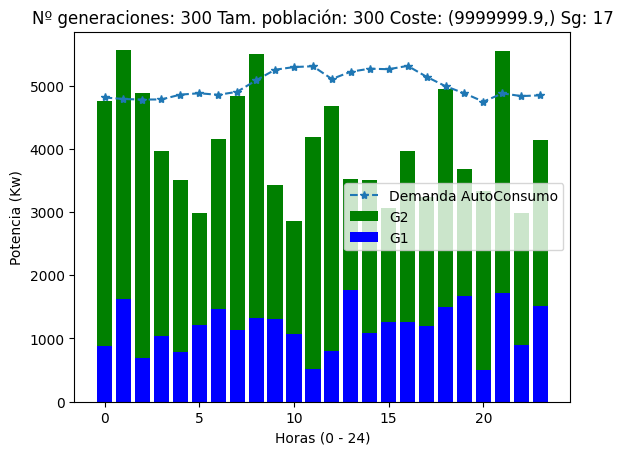

In [124]:
'''
    RESULTADOS
    ---------------------------------------------------------
'''
#Ejecuto funciones para mostrar el resultado de la ejecución
print("Tiempo empleado: ", segundos ," segundos")
print("La mejor solución es: ", pareto_new[0],"   fitness: " , fitness(pareto_new[0]))

tituloGrafico= "Nº generaciones: "+ str(num_generaciones) + " Tam. población: "+ str(tamaño_poblacion) + " Coste: " +str(fitness(pareto_new[0]) )+" Sg: " + str(segundos)
dibujarGrafico(pareto_new[0], demandaConsumoPorHoras_AC, horas,tituloGrafico)

In [128]:
print("   Hora   |  Demanda AC |    U1   |    U2   |  Demanda GC  |   U3   ")
print("-" * 69)

for i in range(len(demandaConsumoPorHoras_AC)):
    print(f"{i:^9} | {demandaConsumoPorHoras_AC[i]:^11.2f} | {pareto_new[0][i]:^7.2f} | {pareto_new[0][i+24]:^7.2f} | {demandaConsumoPorHoras_GC[i]:^12.2f} | {pareto_new[0][i+48]:^7.2f}")


   Hora   |  Demanda AC |    U1   |    U2   |  Demanda GC  |   U3   
---------------------------------------------------------------------
    0     |   4811.00   | 880.21  | 3868.07 |   1200.00    | 3947.64
    1     |   4787.00   | 1628.55 | 3937.71 |   1333.00    | 3162.87
    2     |   4778.00   | 697.88  | 4177.96 |   1444.00    | 3697.92
    3     |   4780.00   | 1042.63 | 2916.87 |   1884.00    | 2060.12
    4     |   4856.00   | 782.99  | 2727.34 |   1884.00    | 3671.66
    5     |   4878.00   | 1209.36 | 1770.03 |   1884.00    | 1747.40
    6     |   4853.00   | 1462.49 | 2695.95 |   1884.00    | 1982.48
    7     |   4901.00   | 1132.60 | 3696.28 |   1884.00    | 3745.95
    8     |   5082.00   | 1325.36 | 4173.75 |   1884.00    | 2654.84
    9     |   5250.00   | 1309.61 | 2119.90 |   1484.00    | 3675.92
   10     |   5292.00   | 1065.88 | 1790.01 |   1584.00    | 3146.59
   11     |   5305.00   | 521.10  | 3672.25 |   1284.00    | 2007.13
   12     |   5103.00   | 803.96 

#Optimización Ejemplos

In [61]:
import random
from tabulate import tabulate

def calcular_costo_deficit(generacion, demanda, costo_horario):
    deficit = generacion - demanda
    if deficit < 0:
        costo_deficit = abs(deficit) * costo_horario
    else:
        costo_deficit = 0
    return costo_deficit

def generar_solucion_inicial(capacidad_unit1, capacidad_unit2, rango_horario):
    generacion_inicial = {}
    for hora in rango_horario:
        generacion_unit1 = random.uniform(400, capacidad_unit1)
        generacion_unit2 = random.uniform(1600, capacidad_unit2)
        generacion_inicial[hora] = (generacion_unit1, generacion_unit2)
    return generacion_inicial

def generar_movimiento(generacion_unit):
    incremento = random.uniform(-0.1, 0.1) * generacion_unit
    nueva_generacion_unit = generacion_unit + incremento
    return max(nueva_generacion_unit, 0)  # Asegurarse de no tener generación negativa

def aplicar_heuristica(capacidad_unit1, capacidad_unit2, demanda_energia, costo_horario, rango_horario, iteraciones):
    mejor_costo_deficit = float('inf')
    mejor_generacion = {}

    for _ in range(iteraciones):
        generacion = generar_solucion_inicial(capacidad_unit1, capacidad_unit2, rango_horario)
        costo_deficit = sum(calcular_costo_deficit(generacion[hora][0] + generacion[hora][1], demanda_energia[hora], costo_horario) for hora in rango_horario)

        for _ in range(100):  # Número fijo de iteraciones de mejora por solución inicial
            nueva_generacion = {}
            for hora in rango_horario:
                generacion_unit1, generacion_unit2 = generacion[hora]
                nueva_generacion_unit1 = generar_movimiento(generacion_unit1)
                nueva_generacion_unit2 = generar_movimiento(generacion_unit2)
                nueva_generacion[hora] = (nueva_generacion_unit1, nueva_generacion_unit2)

            nuevo_costo_deficit = sum(calcular_costo_deficit(nueva_generacion[hora][0] + nueva_generacion[hora][1], demanda_energia[hora], costo_horario) for hora in rango_horario)

            if nuevo_costo_deficit < costo_deficit:
                generacion = nueva_generacion
                costo_deficit = nuevo_costo_deficit
            else:
                break

        if costo_deficit < mejor_costo_deficit:
            mejor_costo_deficit = costo_deficit
            mejor_generacion = generacion

    return mejor_generacion, mejor_costo_deficit

# Ejemplo de uso
capacidad_unit1 = 1800
capacidad_unit2 = 4200
costo_horario = 10
rango_horario = range(24)  # Horas del día (0 a 23)

# Generar demanda de energía aleatoria para cada hora del día
demanda_energia = {hora: random.uniform(2000, 3600) for hora in rango_horario}

iteraciones = 100

mejor_generacion, mejor_costo_deficit = aplicar_heuristica(capacidad_unit1, capacidad_unit2, demanda_energia, costo_horario, rango_horario, iteraciones)

# Preparar los datos para la tabla
tabla_resultados = []
for hora, generacion in mejor_generacion.items():
    fila = [hora, generacion[0], generacion[1], calcular_costo_deficit(generacion[0] + generacion[1], demanda_energia[hora], costo_horario), demanda_energia[hora]]
    tabla_resultados.append(fila)

# Mostrar los resultados en una tabla
headers = ["Hora", "Generación Unidad 1", "Generación Unidad 2", "Costo Déficit", "Demanda"]
tabla = tabulate(tabla_resultados, headers, tablefmt="grid")
print(tabla)



+--------+-----------------------+-----------------------+-----------------+-----------+
|   Hora |   Generación Unidad 1 |   Generación Unidad 2 |   Costo Déficit |   Demanda |
+========+=======================+=======================+=================+===========+
|      0 |               730.387 |               2942.32 |               0 |   3557.17 |
+--------+-----------------------+-----------------------+-----------------+-----------+
|      1 |               800.462 |               3328.29 |               0 |   2971.79 |
+--------+-----------------------+-----------------------+-----------------+-----------+
|      2 |              1175.93  |               4376.4  |               0 |   3537.24 |
+--------+-----------------------+-----------------------+-----------------+-----------+
|      3 |              1437.91  |               3831.88 |               0 |   2615.58 |
+--------+-----------------------+-----------------------+-----------------+-----------+
|      4 |           

In [62]:
import random
from tabulate import tabulate

def calcular_costo_deficit(generacion, demanda, costo_horario):
    deficit = generacion - demanda
    if deficit < 0:
        costo_deficit = abs(deficit) * costo_horario
    else:
        costo_deficit = 0
    return costo_deficit

def generar_solucion_inicial(capacidad_unit1, capacidad_unit2, capacidad_unit3, rango_horario):
    generacion_inicial = {}
    for hora in rango_horario:
        generacion_unit1 = random.uniform(0, capacidad_unit1)
        generacion_unit2 = random.uniform(0, capacidad_unit2)
        generacion_unit3 = random.uniform(0, capacidad_unit3)
        generacion_inicial[hora] = (generacion_unit1, generacion_unit2, generacion_unit3)
    return generacion_inicial

def generar_movimiento(generacion_unit):
    incremento = random.uniform(-0.1, 0.1) * generacion_unit
    nueva_generacion_unit = generacion_unit + incremento
    return max(nueva_generacion_unit, 0)  # Asegurarse de no tener generación negativa

def aplicar_heuristica(capacidad_unit1, capacidad_unit2, capacidad_unit3, demanda_energia, costo_horario, rango_horario, iteraciones):
    mejor_costo_deficit = float('inf')
    mejor_generacion = {}

    for _ in range(iteraciones):
        generacion = generar_solucion_inicial(capacidad_unit1, capacidad_unit2, capacidad_unit3, rango_horario)
        costo_deficit = sum(calcular_costo_deficit(sum(generacion[hora]), demanda_energia[hora], costo_horario) for hora in rango_horario)

        for _ in range(100):  # Número fijo de iteraciones de mejora por solución inicial
            nueva_generacion = {}
            for hora in rango_horario:
                generacion_unit1, generacion_unit2, generacion_unit3 = generacion[hora]
                nueva_generacion_unit1 = generar_movimiento(generacion_unit1)
                nueva_generacion_unit2 = generar_movimiento(generacion_unit2)
                nueva_generacion_unit3 = generar_movimiento(generacion_unit3)
                nueva_generacion[hora] = (nueva_generacion_unit1, nueva_generacion_unit2, nueva_generacion_unit3)

            nuevo_costo_deficit = sum(calcular_costo_deficit(sum(nueva_generacion[hora]), demanda_energia[hora], costo_horario) for hora in rango_horario)

            if nuevo_costo_deficit < costo_deficit:
                generacion = nueva_generacion
                costo_deficit = nuevo_costo_deficit
            else:
                break

        if costo_deficit < mejor_costo_deficit:
            mejor_costo_deficit = costo_deficit
            mejor_generacion = generacion

    return mejor_generacion, mejor_costo_deficit

# Ejemplo de uso
capacidad_unit1 = 1800
capacidad_unit2 = 4200
capacidad_unit3 = 2100  # Capacidad del nuevo generador
costo_horario = 10
rango_horario = range(24)  # Horas del día (0 a 23)

# Generar demanda de energía aleatoria para cada hora del día
# Generar demanda de energía aleatoria para cada hora del día
demanda_energia = {hora: random.uniform(2000, 3600) for hora in rango_horario}

# Generar demanda de energía para la nueva industria
demanda_industria = {hora: random.uniform(500, 2200) for hora in rango_horario}

# Combinar las demandas de las dos industrias
demanda_total = {hora: demanda_energia[hora] + demanda_industria[hora] for hora in rango_horario}

iteraciones = 100

mejor_generacion, mejor_costo_deficit = aplicar_heuristica(capacidad_unit1, capacidad_unit2, capacidad_unit3, demanda_total, costo_horario, rango_horario, iteraciones)

# Preparar los datos para la tabla
tabla_resultados = []
for hora, generacion in mejor_generacion.items():
    generacion_total = sum(generacion)
    demanda_total_hora = demanda_total[hora]
    deficit_industria = max(generacion_total - demanda_industria[hora], 0)
    deficit_energia = max(generacion_total - demanda_energia[hora], 0)
    costo_deficit = calcular_costo_deficit(generacion_total, demanda_total_hora, costo_horario)
    fila = [hora, generacion[0], generacion[1], generacion[2], costo_deficit, deficit_industria, deficit_energia, demanda_total_hora]
    tabla_resultados.append(fila)

# Mostrar los resultados en una tabla
headers = ["Hora", "Generación Unidad 1", "Generación Unidad 2", "Generación Unidad 3", "Costo Déficit", "Déficit Industria", "Déficit Energía", "Demanda Total"]
tabla = tabulate(tabla_resultados, headers, tablefmt="grid")
print(tabla)


+--------+-----------------------+-----------------------+-----------------------+-----------------+---------------------+-------------------+-----------------+
|   Hora |   Generación Unidad 1 |   Generación Unidad 2 |   Generación Unidad 3 |   Costo Déficit |   Déficit Industria |   Déficit Energía |   Demanda Total |
+========+=======================+=======================+=======================+=================+=====================+===================+=================+
|      0 |              262.661  |              2478.64  |              1666.95  |           0     |             3095.92 |         2085.52   |         3635.05 |
+--------+-----------------------+-----------------------+-----------------------+-----------------+---------------------+-------------------+-----------------+
|      1 |               21.3794 |              3309.63  |              1212.06  |           0     |             2466.78 |         2269.24   |         4350.11 |
+--------+-----------------------+

##Optimización PULP

In [63]:
pip install pulp

In [64]:
from pulp import *

# Datos de las unidades hidroeléctricas
gen_max = [1900, 4200, 2100]  # Generación máxima de cada unidad
gen_min = [0, 1600, 400]  # Generación mínima de cada unidad

# Caudal turbina para cada unidad
def caudal_turbina(p):
    return [0.0009 * p[0] + 0.2624, 0.0008 * p[1] + 0.053, 0.0005 * p[2] - 0.0154]

# Precios de energía horaria
precios_energia = [
    6.19, 8.39, 6.19, 6.19, 5.35, 6.48, 5.35, 5.35, 6.19, 6.19, 6.19, 6.48,
    6.19, 6.48, 6.19, 6.48, 6.19, 6.19, 9.46, 9.46, 8.96, 6.19, 6.19, 6.19
]

# Demanda horaria de autoconsumo y gran consumidor
demanda_autoconsumo = [
    4811, 4787, 4778, 4780, 4856, 4878, 4853, 4901, 5082, 5250, 5292, 5305,
    5103, 5219, 5266, 5258, 5311, 5138, 4989, 4876, 4745, 4876, 4833, 4845
]
demanda_gran_consumidor = [
    2114, 2175, 2095, 2248, 2213, 2170, 2172, 2286, 2289, 2213, 2181, 2303,
    2374, 2332, 2200, 2264, 2251, 2162, 2261, 2120, 2028, 2136, 2183, 2198
]

# Crear el problema de optimización
prob = LpProblem("Optimización de generación", LpMinimize)

# Variables de decisión: generación de cada unidad en cada hora
generacion = [
    [LpVariable(f"gen_{i}_{j}", gen_min[i], gen_max[i]) for j in range(24)]
    for i in range(3)
]
# Variable de déficit para el Autoconsumo
deficit_autoconsumo = [LpVariable(f"deficit1_{j}", lowBound=0) for j in range(24)]

# Variable de déficit para el gran consumidor
deficit_gran_consumidor = [LpVariable(f"deficit2_{j}", lowBound=0) for j in range(24)]


# Función objetivo: minimizar el costo de compra de energía de déficit
prob += lpSum([
    precios_energia[j] * deficit_gran_consumidor[j] + precios_energia[j] * deficit_autoconsumo[j]
    for j in range(24)
])

# Restricciones de generación y demanda
for j in range(24):
    # Restricciones de generación mínima y máxima
    for i in range(3):
        prob += generacion[i][j] >= gen_min[i]
        prob += generacion[i][j] <= gen_max[i]

    # Restricción de caudal para unidades 1 y 2
    prob += generacion[0][j] + generacion[1][j] <= generacion[2][j] + 0.8

    # Restricción de demanda de autoconsumo
    #prob += generacion[0][j] + generacion[1][j] >= demanda_autoconsumo[j]

    # Restricción de demanda del gran consumidor
    #prob += generacion[2][j] >= demanda_gran_consumidor[j] + deficit_gran_consumidor[j]

# Resolver el problema de optimización
prob.solve()

# Imprimir el resultado
print("Estado de la solución:", LpStatus[prob.status])
print("Costo de compra de energía de déficit:", value(prob.objective))

# Imprimir la generación óptima de cada unidad en cada hora
for i in range(3):
    print(f"Generación óptima de U{i+1}:")
    for j in range(24):
        print(f"Hora {j+1}: {value(generacion[i][j])}")



Estado de la solución: Optimal
Costo de compra de energía de déficit: 0.0
Generación óptima de U1:
Hora 1: 0.0
Hora 2: 0.0
Hora 3: 0.0
Hora 4: 0.0
Hora 5: 0.0
Hora 6: 0.0
Hora 7: 0.0
Hora 8: 0.0
Hora 9: 0.0
Hora 10: 0.0
Hora 11: 0.0
Hora 12: 0.0
Hora 13: 0.0
Hora 14: 0.0
Hora 15: 0.0
Hora 16: 0.0
Hora 17: 0.0
Hora 18: 0.0
Hora 19: 0.0
Hora 20: 0.0
Hora 21: 0.0
Hora 22: 0.0
Hora 23: 0.0
Hora 24: 0.0
Generación óptima de U2:
Hora 1: 1600.0
Hora 2: 1600.0
Hora 3: 1600.0
Hora 4: 1600.0
Hora 5: 1600.0
Hora 6: 1600.0
Hora 7: 1600.0
Hora 8: 1600.0
Hora 9: 1600.0
Hora 10: 1600.0
Hora 11: 1600.0
Hora 12: 1600.0
Hora 13: 1600.0
Hora 14: 1600.0
Hora 15: 1600.0
Hora 16: 1600.0
Hora 17: 1600.0
Hora 18: 1600.0
Hora 19: 1600.0
Hora 20: 1600.0
Hora 21: 1600.0
Hora 22: 1600.0
Hora 23: 1600.0
Hora 24: 1600.0
Generación óptima de U3:
Hora 1: 2100.0
Hora 2: 2100.0
Hora 3: 2100.0
Hora 4: 2100.0
Hora 5: 2100.0
Hora 6: 2100.0
Hora 7: 2100.0
Hora 8: 2100.0
Hora 9: 2100.0
Hora 10: 2100.0
Hora 11: 2100.0
Hora 1